In [7]:
## ====================================
## EET-4501 – Applied Machine Learning
## Project Assignment 4
## ====================================

In [8]:
## Part 2: Dataset Loading & Basic Exploration

## We load the Robotic Operations Performance Dataset from the provided CSV file.
## This dataset contains operational metrics of industrial robotic systems, including processing time, accuracy, energy consumption, sensor readings, and defect detection indicators.

import pandas as pd
import numpy as np
import re

df = pd.read_csv("robot_dataset.csv")

print("Original Shape:", df.shape)
df.head()

df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

print("Cleaned Column Names:")
print(df.columns)

def extract_numeric(value):
    if pd.isnull(value):
        return np.nan
    match = re.search(r"-?\d+\.?\d*", str(value))
    return float(match.group()) if match else np.nan

if "sensor_data" in df.columns:
    df["sensor_value"] = df["sensor_data"].apply(extract_numeric)
    df.drop(columns=["sensor_data"], inplace=True)
    print("Sensor data cleaned successfully.")
else:
    print("Warning: 'sensor_data' column not found.")

binary_columns = [
    "human_intervention_needed",
    "obstacle_detected",
    "defect_detected"
]

for col in binary_columns:
    if col in df.columns:
        df[col] = df[col].map({"Yes": 1, "No": 0})

id_columns = ["robot_id", "component_id"]

for col in id_columns:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

print("Shape After Cleaning:", df.shape)
df.head()

Original Shape: (500, 12)
Cleaned Column Names:
Index(['robot_id', 'task_type', 'component_id', 'sensor_type', 'sensor_data',
       'processing_time_(s)', 'accuracy_(%)', 'environmental_status',
       'energy_consumption_(kwh)', 'human_intervention_needed',
       'obstacle_detected', 'defect_detected'],
      dtype='object')
Sensor data cleaned successfully.
Shape After Cleaning: (500, 10)


,task_type,sensor_type,processing_time_(s),accuracy_(%),environmental_status,energy_consumption_(kwh),human_intervention_needed,obstacle_detected,defect_detected,sensor_value
0,Inspection,LIDAR,67.0,90.4,Stable,2.2,0,1,1,1.0
1,Assembly,Thermal,71.2,98.1,Stable,2.7,1,0,0,85.3
2,Inspection,Thermal,49.2,95.3,Unstable,2.4,0,0,0,92.0
3,Welding,Camera,74.5,90.2,Stable,2.4,1,0,1,98.0
4,Assembly,Camera,64.5,97.2,Unstable,1.8,0,0,0,92.0


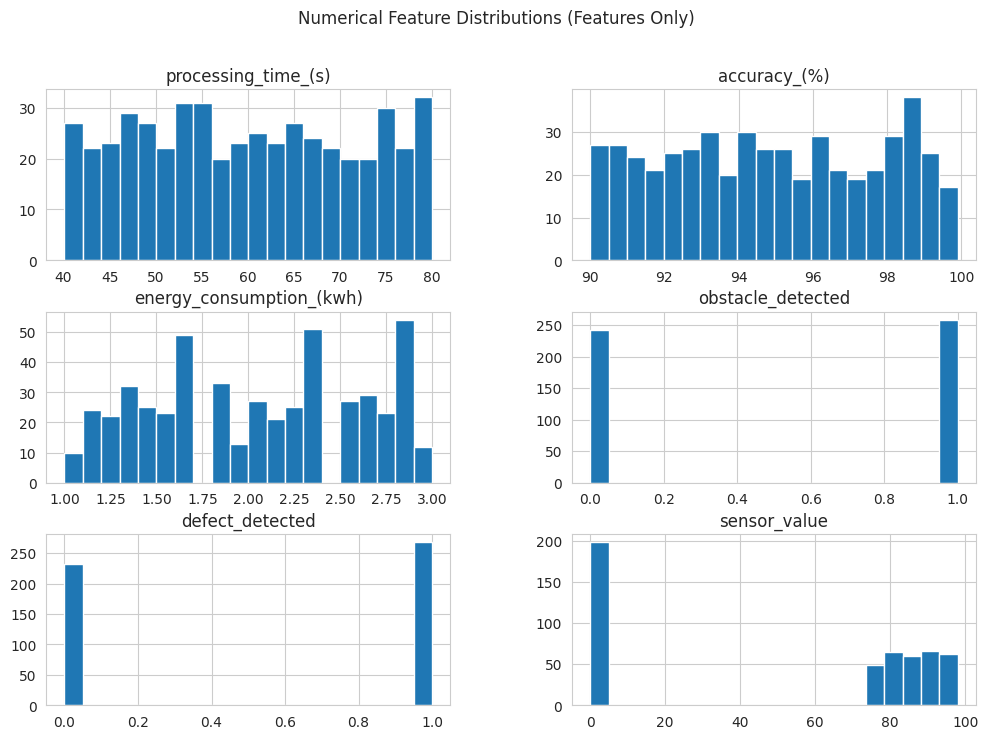

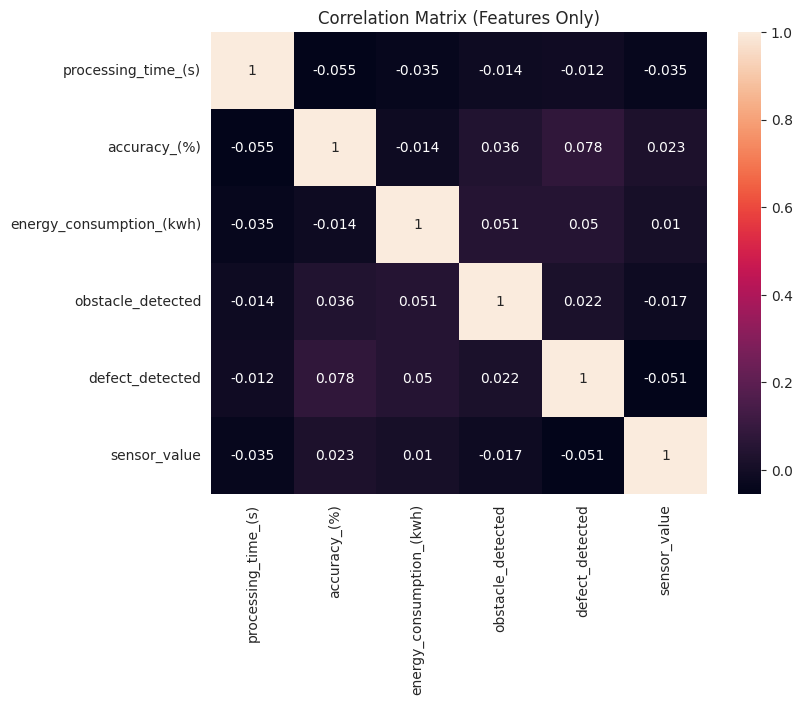

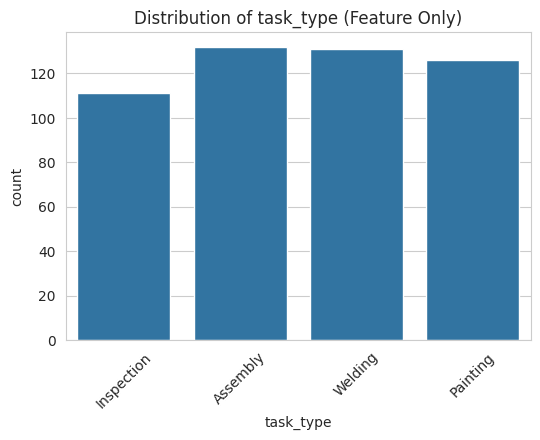

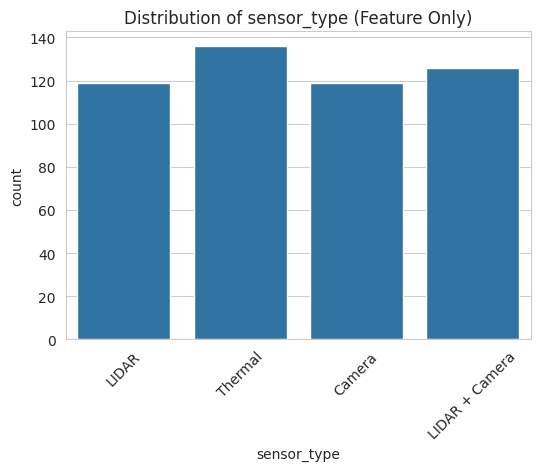

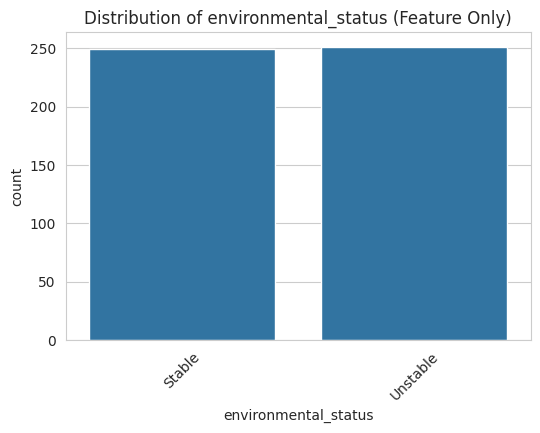

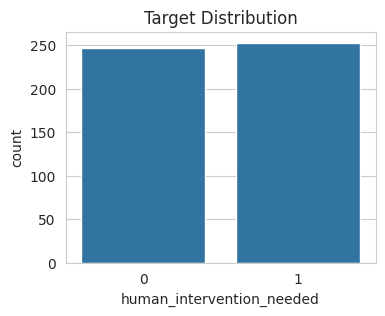

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8,6)

target = "human_intervention_needed"
id_cols = ["robot_id", "component_id"]


numeric_cols = [
    c for c in df.select_dtypes(include=["int64", "float64"]).columns
    if c not in ([target] + id_cols)
]

categorical_cols = [
    c for c in df.select_dtypes(include=["object", "category", "bool"]).columns
    if c not in ([target] + id_cols)
]

# 1) Histograms for numeric features
df[numeric_cols].hist(bins=20, figsize=(12,8))
plt.suptitle("Numerical Feature Distributions (Features Only)")
plt.show()

# 2) Correlation heatmap for numeric features
plt.figure(figsize=(8,6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True)
plt.title("Correlation Matrix (Features Only)")
plt.show()

# 3) Countplots for categorical features
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col} (Feature Only)")
    plt.show()

# plot target separately
plt.figure(figsize=(4,3))
sns.countplot(x=target, data=df)
plt.title("Target Distribution")
plt.show()


In [10]:
## Part 3: Feature Typing & Preprocessing
## We categorize features into numerical and categorical types to build a structured preprocessing pipeline.


import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

target = "human_intervention_needed"
id_cols = ["robot_id", "component_id"]

# Feature engineering
if "accuracy_(%)" in df.columns and "processing_time_(s)" in df.columns:
    df["efficiency_score"] = df["accuracy_(%)"] / df["processing_time_(s)"]

if "accuracy_(%)" in df.columns and "energy_consumption_(kwh)" in df.columns:
    df["energy_efficiency"] = df["accuracy_(%)"] / df["energy_consumption_(kwh)"]

# Separate X and y
X = df.drop(columns=[c for c in [target] + id_cols if c in df.columns]).copy()
y = df[target].copy()


numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numerical Features:", numeric_features)
print("Categorical Features:", categorical_features)

# Pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Fit/transform X only
X_preprocessed = preprocessor.fit_transform(X)
print("Shape After Preprocessing:", X_preprocessed.shape)

# Preview transformed features
feature_names = preprocessor.get_feature_names_out()
X_preview = pd.DataFrame(
    X_preprocessed[:5].toarray() if hasattr(X_preprocessed, "toarray") else X_preprocessed[:5],
    columns=feature_names
)
X_preview


Numerical Features: ['processing_time_(s)', 'accuracy_(%)', 'energy_consumption_(kwh)', 'obstacle_detected', 'defect_detected', 'sensor_value', 'efficiency_score', 'energy_efficiency']
Categorical Features: ['task_type', 'sensor_type', 'environmental_status']
Shape After Preprocessing: (500, 18)


,num__processing_time_(s),num__accuracy_(%),num__energy_consumption_(kwh),num__obstacle_detected,num__defect_detected,num__sensor_value,num__efficiency_score,num__energy_efficiency,cat__task_type_Assembly,cat__task_type_Inspection,cat__task_type_Painting,cat__task_type_Welding,cat__sensor_type_Camera,cat__sensor_type_LIDAR,cat__sensor_type_LIDAR + Camera,cat__sensor_type_Thermal,cat__environmental_status_Stable,cat__environmental_status_Unstable
0,0.604858,-1.559878,0.319474,0.968496,0.930415,-1.209115,-0.877166,-0.634480,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.964536,1.097084,1.178277,-1.032529,-1.074789,0.757764,-0.793372,-0.916300,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-0.919491,0.130916,0.662995,-1.032529,-1.074789,0.914088,0.847514,-0.716378,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.247140,-1.628890,0.662995,-1.032529,0.930415,1.054079,-1.283630,-0.842255,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.390764,0.786530,-0.367567,-1.032529,-1.074789,0.914088,-0.414338,0.130203,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
